<a href="https://colab.research.google.com/github/Emily-KD/PopularityPrediction/blob/main/TripleAttentionFusion/ultabeauty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Use this to manually upload JSON + Rekognition CSVs

Saving faces_final_ultabeauty.csv to faces_final_ultabeauty.csv
Saving labels_final_ultabeauty.csv to labels_final_ultabeauty.csv
Saving ultabeauty_colors.csv to ultabeauty_colors (2).csv
Saving ultabeauty_posts_2024_2025.json to ultabeauty_posts_2024_2025 (2).json


In [ ]:
import pandas as pd
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from transformers import BertTokenizer, BertModel
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
follower_map = {
    "sephora": 22685434,
    "lorealparis": 11539688,
    "rarebeauty": 8273099,
    "kyliecosmetics": 24649706,
    "fentybeauty": 13225537,
    "ultabeauty": 7296937,
    "elfcosmetics": 7427018,
    "yslbeauty": 12292221,
    "hudabeauty": 56976623,
    "charlottetilbury": 7235375
}

# Load JSON post data
json_key = [f for f in uploaded if f.endswith('.json')][0]
with open(json_key, 'r', encoding='utf-8') as f:
    posts = json.load(f)

# Add followers and fallback post_id
brand_name = json_key.split("_")[0].lower()
followers = follower_map.get(brand_name, 1)
for i, p in enumerate(posts):
    p["followers"] = followers
    if "post_id" not in p:
        p["post_id"] = f"post{i}"

# Tokenizer and ER util
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_captions(captions, max_length=128):
    return tokenizer(captions, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
def compute_er(post):
    likes = post.get("likes", 0)
    comments = post.get("comments", 0)
    followers = post.get("followers", None)
    return min((likes + comments) / followers * 100, 100) if followers and followers > 0 else 0.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Extract fields
captions = [p["caption"] for p in posts if p.get("caption")]
time_ids = torch.tensor([datetime.fromisoformat(p["timestamp"]).hour for p in posts], dtype=torch.long)
lda_topic_vecs = torch.rand(len(posts), 10)
hist_ers = torch.tensor([[compute_er(p)] for p in posts], dtype=torch.float)
brand_ids = torch.zeros(len(posts), dtype=torch.long)

# Encoders
class TextEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased', use_cls=True, output_dim=256, dropout=0.2):
        super(TextEncoder, self).__init__()
        self.use_cls = use_cls
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, output_dim)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0] if self.use_cls else outputs.last_hidden_state.mean(dim=1)
        return self.linear(self.dropout(pooled))

class ContextEncoder(nn.Module):
    def __init__(self, num_brands, num_time_bins, lda_dim=10, context_dim=128):
        super(ContextEncoder, self).__init__()
        self.brand_embedding = nn.Embedding(num_brands, 32)
        self.time_embedding = nn.Embedding(num_time_bins, 16)
        self.encoder = nn.Sequential(
            nn.Linear(32 + 16 + lda_dim + 1, context_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
    def forward(self, brand_id, time_id, lda_topic_vec, hist_er):
        return self.encoder(torch.cat([
            self.brand_embedding(brand_id),
            self.time_embedding(time_id),
            lda_topic_vec,
            hist_er
        ], dim=1))

In [ ]:
# Generate caption/context embeddings
tokens = tokenize_captions(captions)
input_ids, attention_mask = tokens["input_ids"].to(device), tokens["attention_mask"].to(device)
text_model = TextEncoder().to(device).eval()
context_model = ContextEncoder(num_brands=1, num_time_bins=24).to(device).eval()
with torch.no_grad():
    text_input = text_model(input_ids, attention_mask)
    context_input = context_model(brand_ids, time_ids, lda_topic_vecs, hist_ers)
y_true = hist_ers[:len(text_input)].view(-1)

# Load and process Rekognition features
faces_df = pd.read_csv("faces_final_ultabeauty.csv")
labels_df = pd.read_csv("labels_final_ultabeauty.csv")
colors_df = pd.read_csv("ultabeauty_colors.csv")
for df in [faces_df, labels_df, colors_df]:
    df["post_id"] = df["image_id"].str.extract(r"(post\d+)_img\d+")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
agg = lambda x: x.mode().iloc[0] if not x.mode().empty else "none"
faces_agg = faces_df.groupby("post_id").agg({"face_count": "mean", "emotions": agg}).reset_index()
labels_agg = labels_df.groupby("post_id").agg({"has_makeup": "max", "has_beauty_product": "max"}).reset_index()
colors_agg = colors_df.groupby("post_id").agg({"dominantColor": agg}).reset_index()
image_feats = faces_agg.merge(labels_agg, on="post_id", how="outer").merge(colors_agg, on="post_id", how="outer")

posts_df = pd.DataFrame(posts)
merged_df = posts_df.merge(image_feats, on="post_id", how="left")
merged_df.fillna({"emotions": "none", "dominantColor": "none", "face_count": 0}, inplace=True)


In [ ]:
# Encode visual features (updated for scikit-learn >= 1.2)
encoded = OneHotEncoder(sparse_output=False).fit_transform(merged_df[["emotions", "dominantColor"]])
scaled = StandardScaler().fit_transform(merged_df[["face_count"]])
other = merged_df[["has_makeup", "has_beauty_product"]].fillna(0).astype(float).values
X_image = torch.tensor(np.hstack([scaled, other, encoded]), dtype=torch.float)

class ImageEncoder(nn.Module):
    def __init__(self, input_dim, output_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, output_dim), nn.ReLU()
        )
    def forward(self, x): return self.net(x)

class TripleAttentionFusionModel(nn.Module):
    def __init__(self, text_dim=256, context_dim=128, image_dim=64, fusion_dim=128):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(text_dim + context_dim + image_dim, fusion_dim), nn.ReLU(), nn.Dropout(0.2)
        )
        self.regressor = nn.Sequential(
            nn.Linear(fusion_dim, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, t, c, i): return self.regressor(self.fusion(torch.cat([t, c, i], dim=1))).squeeze(1)


In [ ]:
# Train model
image_model = ImageEncoder(X_image.shape[1], 64).to(device).eval()
with torch.no_grad():
    image_input = image_model(X_image[:len(text_input)].to(device))

model = TripleAttentionFusionModel().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
losses = []
for epoch in range(100):
    model.train()
    opt.zero_grad()
    # Ensure all inputs have the same number of samples in dimension 0
    min_len = min(len(text_input), len(context_input), len(image_input), len(y_true))
    loss = crit(model(text_input[:min_len], context_input[:min_len], image_input[:min_len]), y_true[:min_len])
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 3.2051
Epoch 10 | Loss: 2.6022
Epoch 20 | Loss: 1.9601
Epoch 30 | Loss: 0.8362
Epoch 40 | Loss: 0.1590
Epoch 50 | Loss: 0.1170
Epoch 60 | Loss: 0.0962
Epoch 70 | Loss: 0.0340
Epoch 80 | Loss: 0.0382
Epoch 90 | Loss: 0.0469


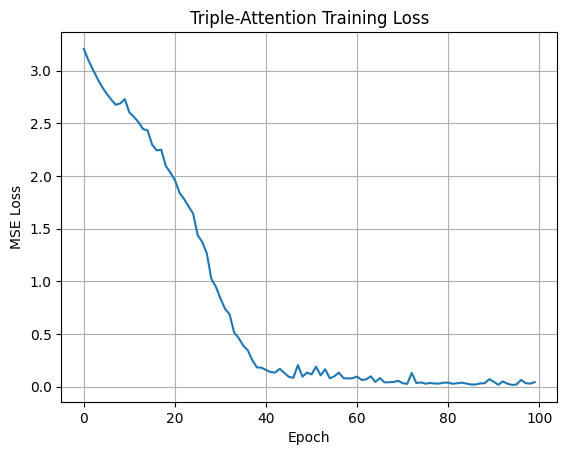

In [ ]:
plt.plot(losses)
plt.title("Triple-Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


In [ ]:
# Evaluation: Metrics and Scatterplot
from sklearn.metrics import r2_score, mean_absolute_error

model.eval()
with torch.no_grad():
    # Ensure all inputs have the same number of samples before evaluation
    min_len = min(len(text_input), len(context_input), len(image_input), len(y_true))
    preds = model(text_input[:min_len], context_input[:min_len], image_input[:min_len]).cpu().numpy()
    targets = y_true[:len(preds)].cpu().numpy()  # or y_true[:min_len].cpu().numpy() for consistency

r2 = r2_score(targets, preds)
mae = mean_absolute_error(targets, preds)

print(f"\n📊 Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# ... (rest of your evaluation code)


📊 Model Evaluation:
R² Score: 0.9958
MAE: 0.0699


In [ ]:

# 1. Text-Only Model
class TextOnlyModel(nn.Module):
    def __init__(self, text_dim=256):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(text_dim, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, text):
        return self.regressor(text).squeeze(1)

In [ ]:
# 2. Text + Context Model
class TextContextModel(nn.Module):
    def __init__(self, text_dim=256, context_dim=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(text_dim + context_dim, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, t, c):
        return self.regressor(torch.cat([t, c], dim=1)).squeeze(1)


In [ ]:
# 3. Image-Only Model
class ImageOnlyModel(nn.Module):
    def __init__(self, image_dim=64):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(image_dim, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, image):
        return self.regressor(image).squeeze(1)


In [ ]:
# Utility to train and evaluate a model

def train_and_evaluate(model, inputs, target, name="Model"):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit = nn.MSELoss()
    losses = []
    for epoch in range(100):
        model.train()
        opt.zero_grad()

        # Ensure all inputs have the same number of samples in dimension 0 before passing to model
        min_len = min(len(inp) for inp in inputs)

        # Slice inputs to the minimum length
        sliced_inputs = [inp[:min_len] for inp in inputs]

        preds = model(*sliced_inputs) # Pass sliced inputs to model
        loss = crit(preds, target[:min_len]) # Slice target as well
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % 20 == 0:
            print(f"[{name}] Epoch {epoch} | Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        # Slice inputs to the minimum length for evaluation
        min_len = min(len(inp) for inp in inputs)
        sliced_inputs = [inp[:min_len] for inp in inputs]

        preds = model(*sliced_inputs).cpu().numpy()  # Pass sliced inputs to model
        y = target[:min_len].cpu().numpy() # Slice target as well

    r2 = r2_score(y, preds)
    mae = mean_absolute_error(y, preds)
    print(f"\n{name} Results → R²: {r2:.4f} | MAE: {mae:.4f}\n")
    return model, losses

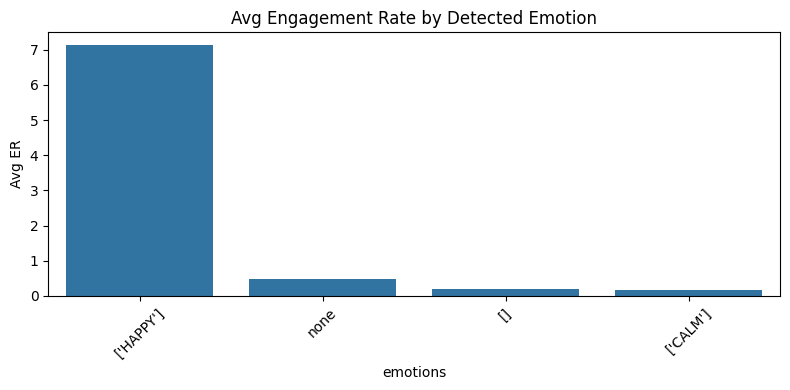

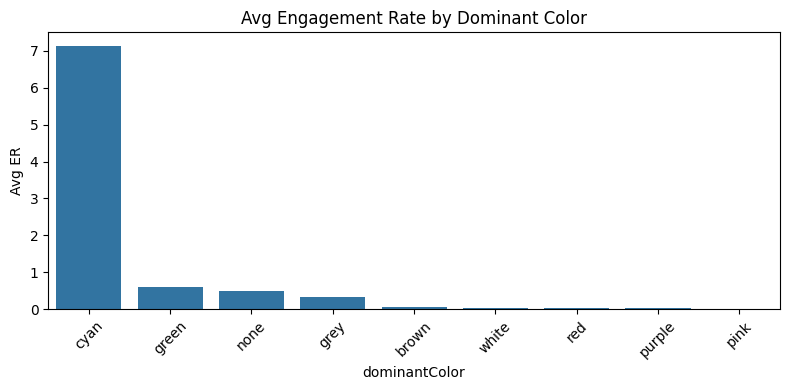

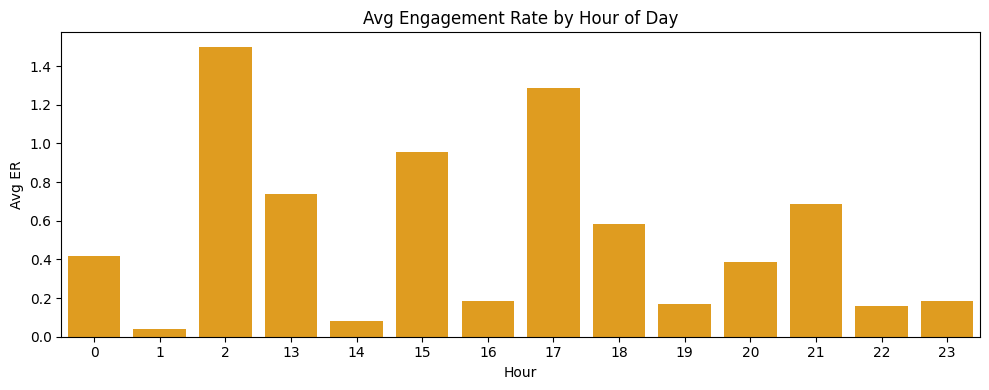

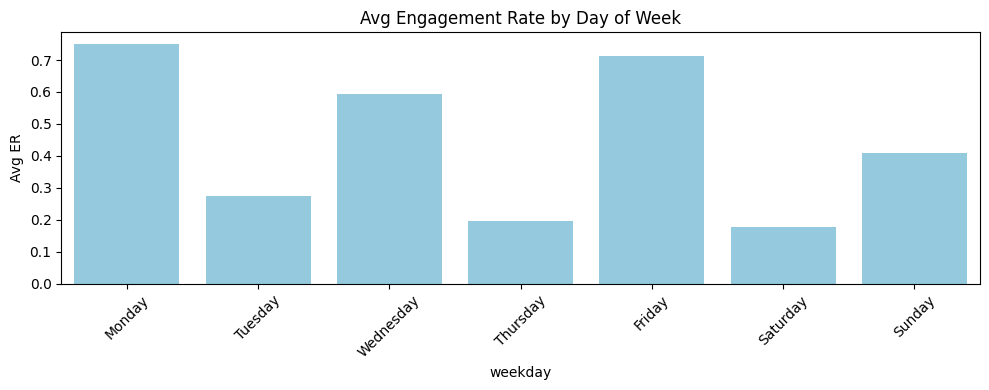

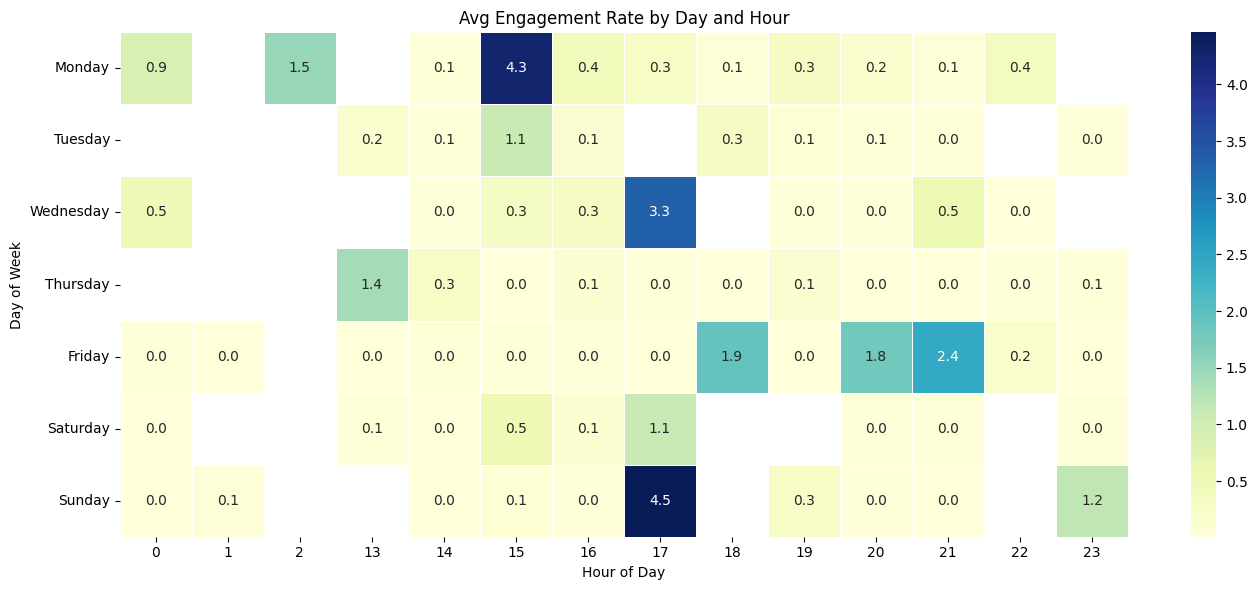

In [ ]:
# 📈 Visual Traits and ER
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import shap
from shap import GradientExplainer

# Compute engagement_rate column if missing
if "engagement_rate" not in merged_df.columns:
    merged_df["engagement_rate"] = merged_df.apply(lambda row: compute_er(row), axis=1)

# Merge predictions with visuals
# Include merged_df length in min_len calculation to handle potential mismatches
min_len = min(len(text_input), len(context_input), len(image_input), len(merged_df))

# Run model and get predictions
pred_er = model(text_input[:min_len], context_input[:min_len], image_input[:min_len]).detach().cpu().numpy().flatten()

# Assign predictions to a sliced version of the DataFrame
merged_df = merged_df.iloc[:min_len].copy()  # slice and copy to avoid SettingWithCopyWarning
merged_df["pred_er"] = pred_er


# Average ER by emotion and dominant color
emotion_er = merged_df.groupby("emotions")["engagement_rate"].mean().sort_values(ascending=False)
color_er = merged_df.groupby("dominantColor")["engagement_rate"].mean().sort_values(ascending=False)

# ... (Rest of your visualization code remains unchanged)
# Plot emotion impact
plt.figure(figsize=(8, 4))
sns.barplot(x=emotion_er.index, y=emotion_er.values)
plt.title("Avg Engagement Rate by Detected Emotion")
plt.ylabel("Avg ER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot color impact
plt.figure(figsize=(8, 4))
sns.barplot(x=color_er.index, y=color_er.values)
plt.title("Avg Engagement Rate by Dominant Color")
plt.ylabel("Avg ER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📅 Best Times & Days to Post
from datetime import datetime  # make sure this is imported

# Align post timestamps to match the DataFrame length
timestamps = [datetime.fromisoformat(p["timestamp"]) for p in posts[:len(merged_df)]]
merged_df["timestamp"] = timestamps

merged_df["hour"] = merged_df["timestamp"].dt.hour
merged_df["weekday"] = merged_df["timestamp"].dt.strftime("%A")

# ER by hour
hour_er = merged_df.groupby("hour")["engagement_rate"].mean()
plt.figure(figsize=(10, 4))
sns.barplot(x=hour_er.index, y=hour_er.values, color="orange")
plt.title("Avg Engagement Rate by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg ER")
plt.tight_layout()
plt.show()

# ER by weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_er = merged_df.groupby("weekday")["engagement_rate"].mean().reindex(weekday_order)
plt.figure(figsize=(10, 4))
sns.barplot(x=weekday_er.index, y=weekday_er.values, color="skyblue")
plt.title("Avg Engagement Rate by Day of Week")
plt.ylabel("Avg ER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ⏰ Heatmap: day vs hour
pivot_table = merged_df.pivot_table(index="weekday", columns="hour", values="engagement_rate", aggfunc="mean").reindex(index=weekday_order)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".1f")
plt.title("Avg Engagement Rate by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


[Text-Only] Epoch 0 | Loss: 3.0427
[Text-Only] Epoch 20 | Loss: 2.7472
[Text-Only] Epoch 40 | Loss: 2.5939
[Text-Only] Epoch 60 | Loss: 2.3854
[Text-Only] Epoch 80 | Loss: 2.1353

Text-Only Results → R²: 0.3493 | MAE: 0.5744



<ipython-input-21-742f9b5ef596>:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

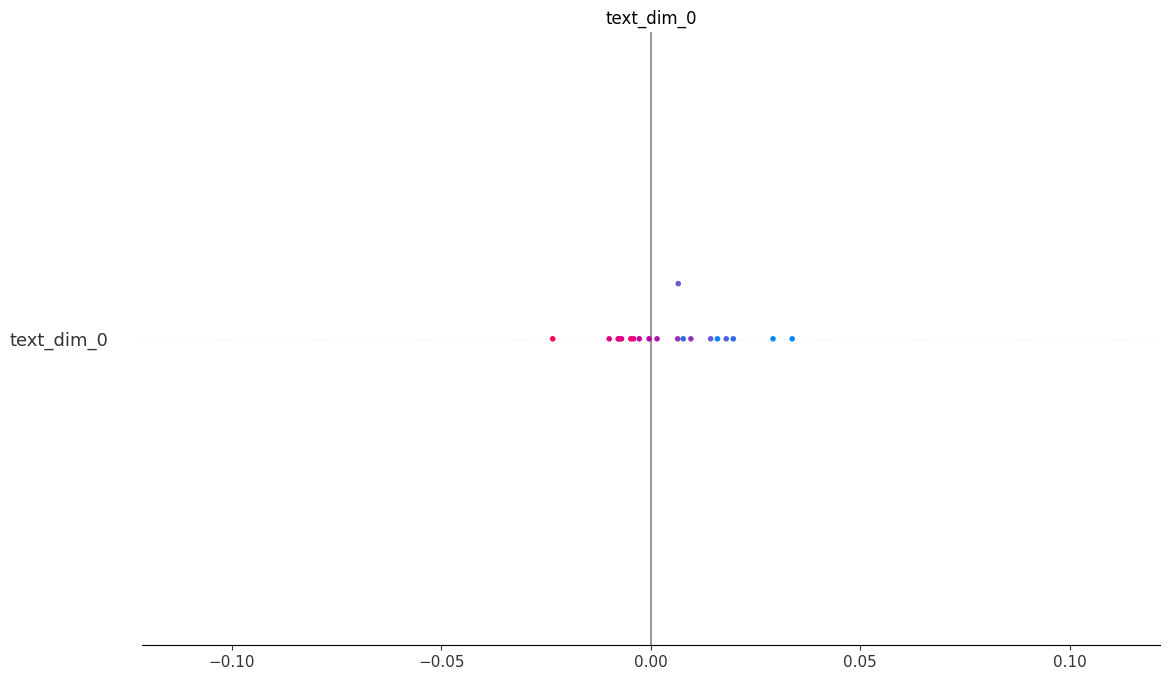

In [ ]:
# 1. Text-Only Model
class TextOnlyModel(nn.Module):
    def __init__(self, text_dim=256):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(text_dim, 64), nn.ReLU(), nn.Linear(64, 1)
        )
    def forward(self, text):
        return self.regressor(text).squeeze(1)

# Instantiate and train the TextOnlyModel
text_only_model = TextOnlyModel() # Instantiate the model
text_only_model, _ = train_and_evaluate(text_only_model, [text_input], y_true, name="Text-Only") # Train and evaluate


# Wrap your model to return 2D output (batch_size, 1)
class WrappedTextModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    def forward(self, x):
        return self.base_model(x).unsqueeze(1)  # shape: (batch_size, 1)

# Create wrapped model and send to device
wrapped_model = WrappedTextModel(text_only_model).to(device)
wrapped_model.eval()

# SHAP GradientExplainer
explainer = shap.GradientExplainer(wrapped_model, text_input[:100])  # background data

# Compute SHAP values for first 20 samples
shap_values = explainer.shap_values(text_input[:20])

# Plot
shap.summary_plot(
    shap_values,
    features=text_input[:20].cpu().numpy(),
    feature_names=[f"text_dim_{i}" for i in range(text_input.shape[1])]
)

<ipython-input-22-f162f59b3d72>:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


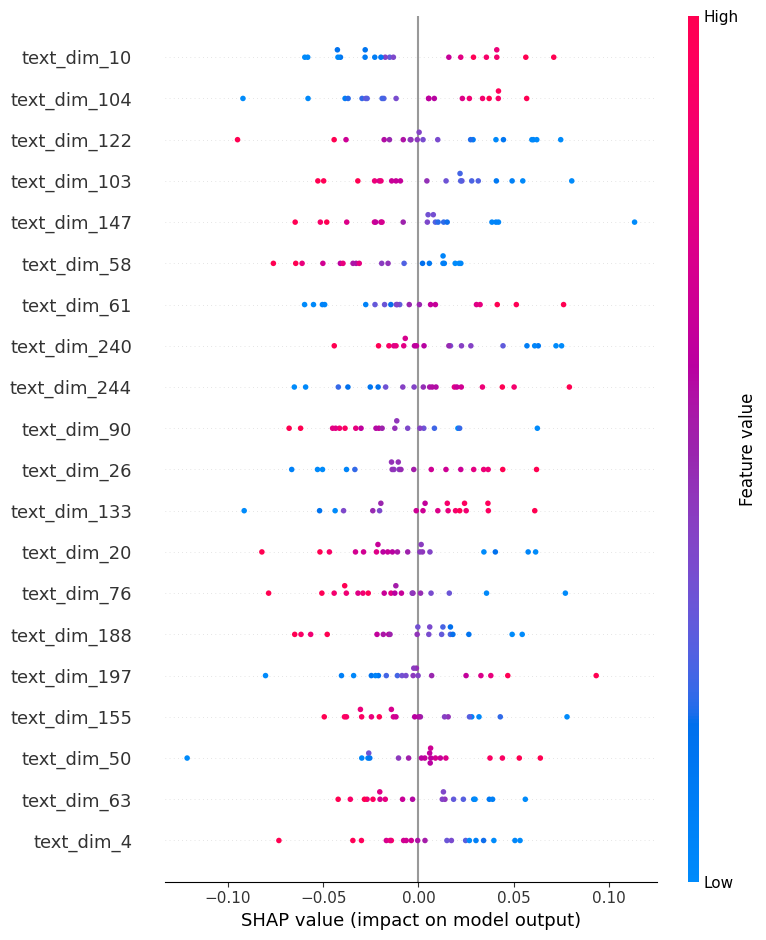

In [ ]:
# Remove the singleton output dimension
shap_values_squeezed = shap_values.squeeze(-1)  # now shape = (20, 256)

# Replot with proper shape
shap.summary_plot(
    shap_values_squeezed,
    text_input[:20].cpu().numpy(),
    feature_names=[f"text_dim_{i}" for i in range(text_input.shape[1])]
)


In [ ]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(20, 256, 1)


In [ ]:
# Select a text dimension you're curious about
target_dim = 204  # change this to try others like 17, 86, etc.

# Re-encode the captions
tokens = tokenize_captions(captions)
input_ids = tokens["input_ids"].to(device)
attention_mask = tokens["attention_mask"].to(device)

# Pass through BERT encoder
text_model.eval()
with torch.no_grad():
    encoded = text_model(input_ids, attention_mask).cpu().numpy()

# Find top captions that activate this dimension
top_indices = encoded[:, target_dim].argsort()[::-1]  # highest to lowest

# Show the top 5 captions with strongest activation for this dim
print(f"\n🔍 Top Captions Activating text_dim_{target_dim}:\n")
for i in top_indices[:5]:
    print(f"→ [{i}] Score: {encoded[i, target_dim]:.4f}")
    print(captions[i])
    print("-----")



🔍 Top Captions Activating text_dim_204:

→ [80] Score: 0.1647
👏 Here she is 👏 Meet the new I NEED A WARM EYESHADOW PALETTE 🤩 The ultimate neutral-warm version of the viral I NEED A NUDE EYESHADOW PALETTE. Featuring 2 brand new innovative formulas - SLIP CREAM MATTE and METAL GLOSS!! With a blend of metallic champagnes, rich caramels, shimmering rosy coppers, essential browns, and a fun color-shifting triochrome – this versatile palette is perfect for all skin tones 🤎✨

Officially launching August 22nd on www.natashadenona.com & online @ultabeauty (in stores August 25th) 😍

I NEED A WARM PALETTE - $69 

SHADE DESCRIPTIONS:
Soft Spot 550CM - Matte medium earthy brown
Fancy 551M - Metallic champagne
Mellow 552CM - Matte light peachy nude
Phenomena 553MC - Multichrome peach pink green
Ripe 554CM - Matte light medium peach brown
Elm 555SF - Sparkling Foiled light bronzy nude
Snug 557MG - Metal Gloss soft bronze
Vim 556CM - Matte deep warm brown
Push 559SF - Sparkling Foiled medium rusty ro

In [ ]:
color_er = merged_df.groupby("dominantColor")["engagement_rate"].mean().sort_values(ascending=False)
print(color_er.head(10))  # Top 10 most engaging dominant colors


dominantColor
cyan      7.140284
green     0.610640
none      0.484762
grey      0.320951
brown     0.063584
white     0.035746
red       0.031808
purple    0.027477
pink      0.018117
Name: engagement_rate, dtype: float64


In [ ]:
import pandas as pd
import re
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('punkt_tab') # This line was missing


stop_words = set(stopwords.words("english"))
word_to_ers = defaultdict(list)

# Make sure 'captions' and 'merged_df["engagement_rate"]' align
for caption, er in zip(captions[:len(merged_df)], merged_df["engagement_rate"]):
    # Preprocess + tokenize
    caption = caption.lower()
    caption = re.sub(r"[^\w\s]", "", caption)  # Remove punctuation
    words = word_tokenize(caption)

    # Filter out stopwords and short tokens
    words = [w for w in words if w not in stop_words and len(w) > 2]

    for word in set(words):  # use set to avoid duplicates in same caption
        word_to_ers[word].append(er)

# Compute average ER per word
word_avg_er = {word: sum(ers)/len(ers) for word, ers in word_to_ers.items() if len(ers) >= 3}  # only include words used at least 3 times

# Get top 5
top_words = sorted(word_avg_er.items(), key=lambda x: x[1], reverse=True)[:5]

# Print results
print("\n🔝 Top 5 Words with Highest Avg Engagement Rate:")
for word, avg_er in top_words:
    print(f"'{word}' → Avg ER = {avg_er:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...



🔝 Top 5 Words with Highest Avg Engagement Rate:
'nationwide' → Avg ER = 7.4308
'weightless' → Avg ER = 5.3383
'lasts' → Avg ER = 5.2772
'formula' → Avg ER = 4.1759
'person' → Avg ER = 3.9877


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


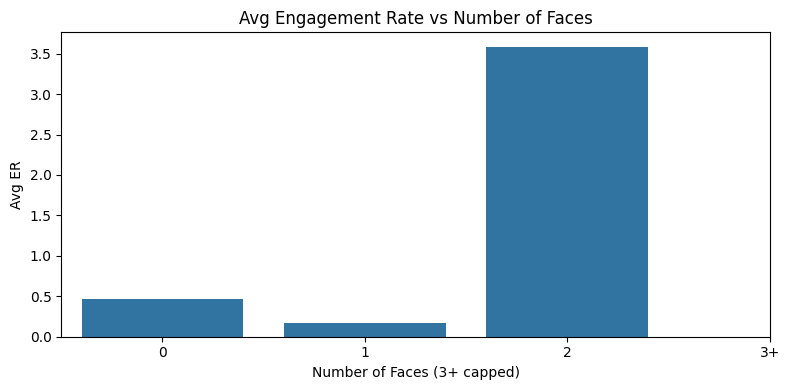

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Round face counts into bins (e.g., 0, 1, 2, 3+)
merged_df["face_bin"] = merged_df["face_count"].apply(lambda x: int(x) if x < 3 else 3)

# Calculate average ER per face_bin
face_er = merged_df.groupby("face_bin")["engagement_rate"].mean()

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=face_er.index, y=face_er.values)
plt.title("Avg Engagement Rate vs Number of Faces")
plt.xlabel("Number of Faces (3+ capped)")
plt.ylabel("Avg ER")
plt.xticks([0, 1, 2, 3], ["0", "1", "2", "3+"])
plt.tight_layout()
plt.show()


In [ ]:
print(face_er)

face_bin
0    0.460734
1    0.172474
3    3.583997
Name: engagement_rate, dtype: float64
